In [32]:
# This is the library import session.
import sys # system parameter
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
import pandas as pd # database processing package similar to SQL
import time as time
# Common Machine Learning Algorithms
from sklearn import svm, tree, linear_model, neighbors, \
naive_bayes, ensemble, discriminant_analysis, gaussian_process
#from xgboost import XGBClassifier missing wait for add
#Common Model Helper package
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#Configure Visualization Defaults
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12, 8

In [3]:
# Data import
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_test = train_df.copy(deep = True)
data_cleaner = [train_test, test_df]

In [4]:
# Data preview and exploration
train_df.info()
train_df.sample(10)
train_df.groupby('Survived').count()
print('Train Columns with null:\n', train_test.isnull().sum())
print("-" * 10)

print('Test/Validation columns with null:\n', test_df.isnull().sum())
print("-" * 10)

train_df.describe(include = 'all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
Train Columns with null:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Allen, Miss. Elisabeth Walton",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [5]:
# Data Cleaning
for dataset in data_cleaner:
    # fill the missing data with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
    
    #Complete Embark information with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True) #mode is the number with largest frequency
    #complete the missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
drop_column = ['PassengerId', 'Cabin', 'Ticket']
train_test.drop(drop_column, axis=1, inplace=True)
    
print(train_test.isnull().sum())
print("-" * 10)
print(test_df.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [6]:
### Feature engineering for train and test/validation dataset
for dataset in data_cleaner:
    # count the total number of family number
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    dataset['IsAlone'] = 1 # use 1 to denote alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0
    # filter out the title like Mr. Ms. Miss etc
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1]\
    .str.split(".", expand = True)[0]
    # catogorize using the frequency distribution 0%, 25%, 50%, 75%, 100%
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    #catogorize using the age range evenly separated into 5
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)

stat_min = 10
title_names = (train_test['Title'].value_counts() < stat_min)
    
train_test['Title'] = train_test['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(train_test['Title'].value_counts())
print("-" * 10)
    
train_test.info()
test_df.info()
train_test.sample(10)
print(train_test['Title'].value_counts())

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null object
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Title         891 non-null object
FareBin       891 non-null category
AgeBin        891 non-null category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null 

In [7]:
# convert objects to category using label encoder for train
# test/validation dataset

label = LabelEncoder()
for dataset in data_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    

# define target variable
Target = ['Survived']
# Input variable aka feature selection

train_test_x = ['Sex', 'Pclass','Embarked', 'Title','SibSp'
                , 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] # original column name in charts
train_test_x_code = ['Sex_Code','Pclass', 'Embarked_Code', 
                   'Title_Code','SibSp', 'Parch', 'Age', 
                   'Fare'] # coded column names for algorithm
train_test_xy = Target + train_test_x
print('Original X Y: ', train_test_xy, '\n')

#define x variables for original w/bin features to remove continuous variables
train_test_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
train_test_xy_bin = Target + train_test_x_bin
print('Bin X Y: ', train_test_xy_bin, '\n')

#define x and y variables for dummy features original
train_test_dummy = pd.get_dummies(train_test[train_test_x])
train_test_x_dummy = train_test_dummy.columns.tolist()
train_test_xy_dummy = Target + train_test_x_dummy
print('Dummy X Y: ', train_test_xy_dummy, '\n')

train_test_dummy.head()
train_test.head()


Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]",1,2,3,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,0,4,2,3
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]",0,2,2,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,2,4,2,3
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]",1,2,3,2,1


In [8]:
# Double check the cleaned data
print('Train columns with null values: \n', train_test.isnull().sum())
print('-' * 10)
print(train_test.info())
print("-" * 10)
print('Test/Validation columns with null values: \n', test_df.isnull().sum())
print("-"*10)
print (test_df.info())
print("-"*10)

train_df.describe(include = 'all')

Train columns with null values: 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
FamilySize       891 non-null int64
IsAlone          891 non-null int64
Title            891 non-null object
FareBin          891 non-null catego

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Allen, Miss. Elisabeth Walton",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [9]:
train1_x, test1_x, train1_y, test1_y = \
model_selection.train_test_split(train_test[train_test_x_code],\
                                 train_test[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = \
model_selection.train_test_split(train_test[train_test_x_bin], \
                                 train_test[Target], random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy= \
model_selection.train_test_split(train_test_dummy[train_test_x_dummy], \
                                 train_test[Target], random_state = 0)

print("train_test shape:{}".format(train_test.shape))
print("train1 Shape: {}".format(train1_x.shape))
print("test1 Shape: {}".format(test1_x.shape))

train_test shape:(891, 19)
train1 Shape: (668, 8)
test1 Shape: (223, 8)


# Perform Exploratory Analysis with Statisticsm

In [10]:
#Discrete Variable Correlation by Survival using
#group by aka pivot table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html
for x in train_test_x:
    if train_test[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(train_test[[x, Target[0]]].
              groupby(x, as_index = False).mean())
        print('-' * 10, '\n')



Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303538
1 

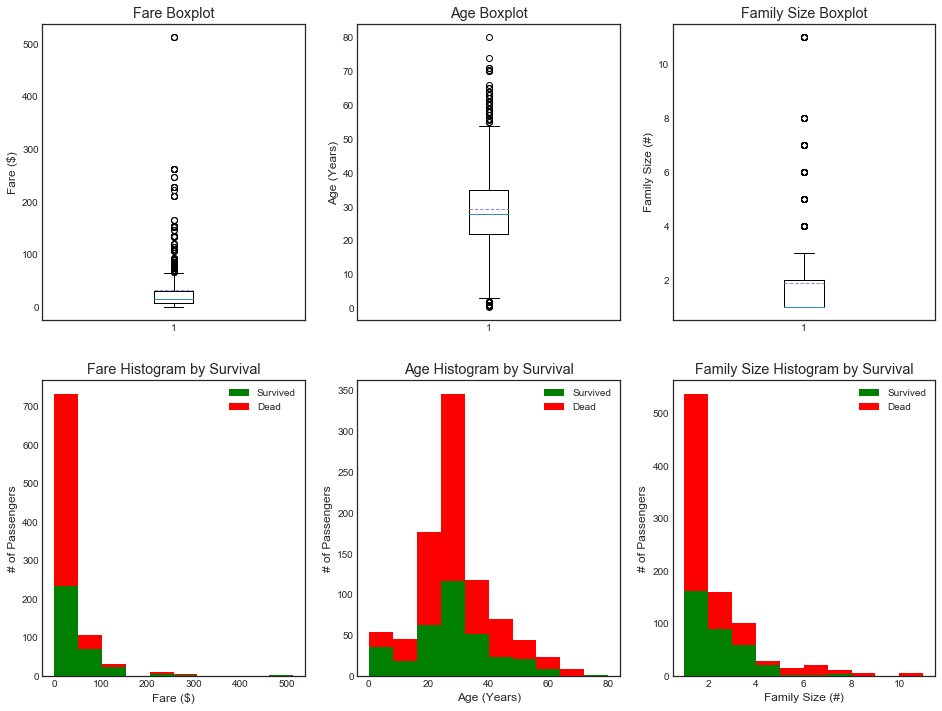

In [11]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])
plt.subplot(231)
plt.boxplot(x = train_test['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(x = train_test['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(train_test['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [train_test[train_test['Survived'] == 1]['Fare'],
             train_test[train_test['Survived'] == 0]['Fare']], 
             stacked = True, color = ['g', 'r'],
             label = ['Survived', 'Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [train_test[train_test['Survived']==1]['Age'], train_test[train_test['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [train_test[train_test['Survived']==1]['FamilySize'],
              train_test[train_test['Survived']==0]['FamilySize']], 
              stacked=True, color = ['g','r'], 
              label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

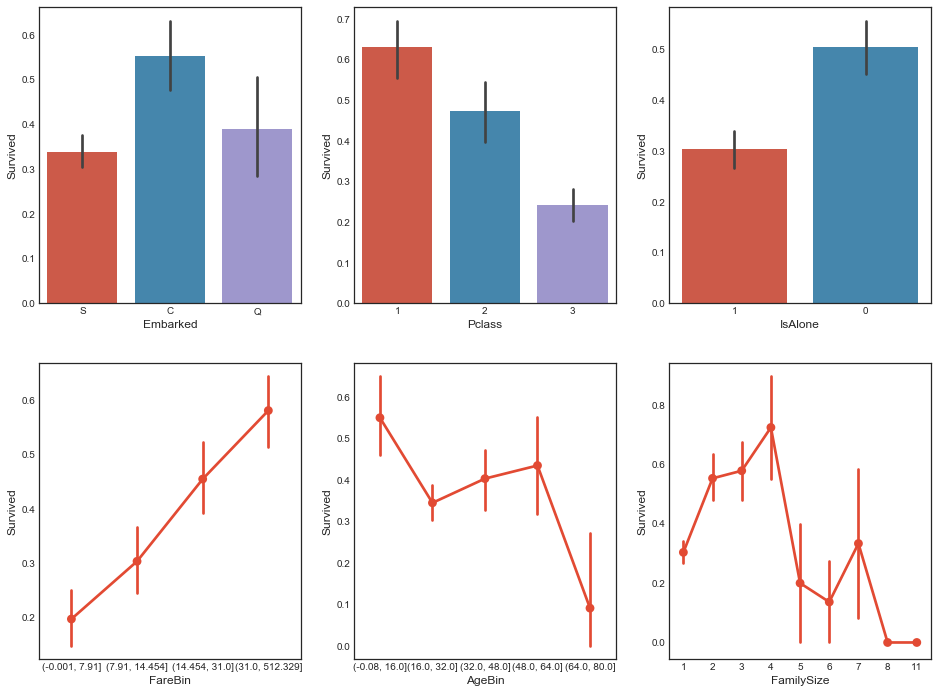

In [12]:
#graph individual features by survival
fig, saxis = plt.subplots(2, 3, figsize = (16, 12))

sns.barplot(x = 'Embarked', y = 'Survived',
           data = train_test, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order = [1,2,3],
            data=train_test, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0],
            data=train_test, ax = saxis[0,2])
sns.pointplot(x = 'FareBin', y = 'Survived',
              data=train_test, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived',
              data=train_test, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived',
              data=train_test, ax = saxis[1,2])

Text(0.5,1,'Pclass vs Family Size Survival Comparison')

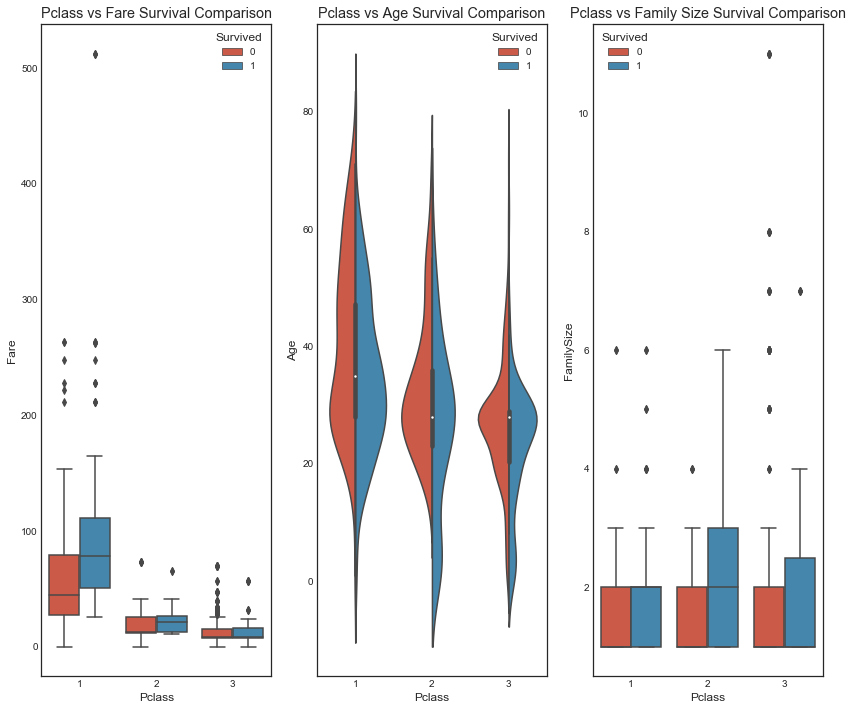

In [13]:
#graph distribution of qualitative data: Pclass
#we know class mattered in survival, now let's compare class and a 2nd feature
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize = (14, 12))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived',
           data = train_test, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = train_test, split = True, ax = axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y ='FamilySize', hue = 'Survived', data = train_test, ax = axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')

Text(0.5,1,'Sex vs IsAlone Survival Comparison')

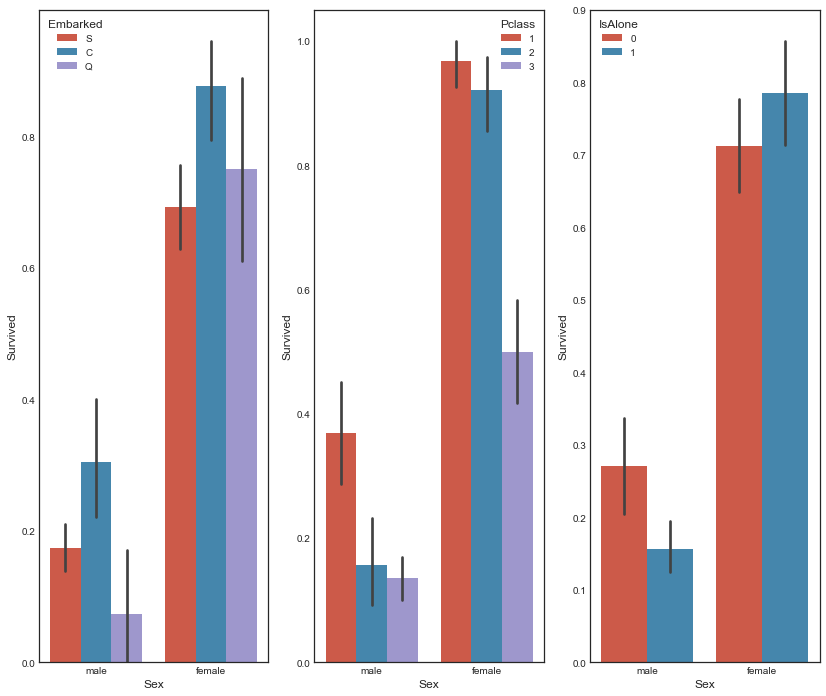

In [14]:
#graph distribution of qualitative data: Sex
#we know sex mattered in survival, now let's compare sex and a 2nd feature
fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data=train_test, ax = qaxis[0])
axis1.set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data=train_test, ax  = qaxis[1])
axis1.set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone', data=train_test, ax  = qaxis[2])
axis1.set_title('Sex vs IsAlone Survival Comparison')

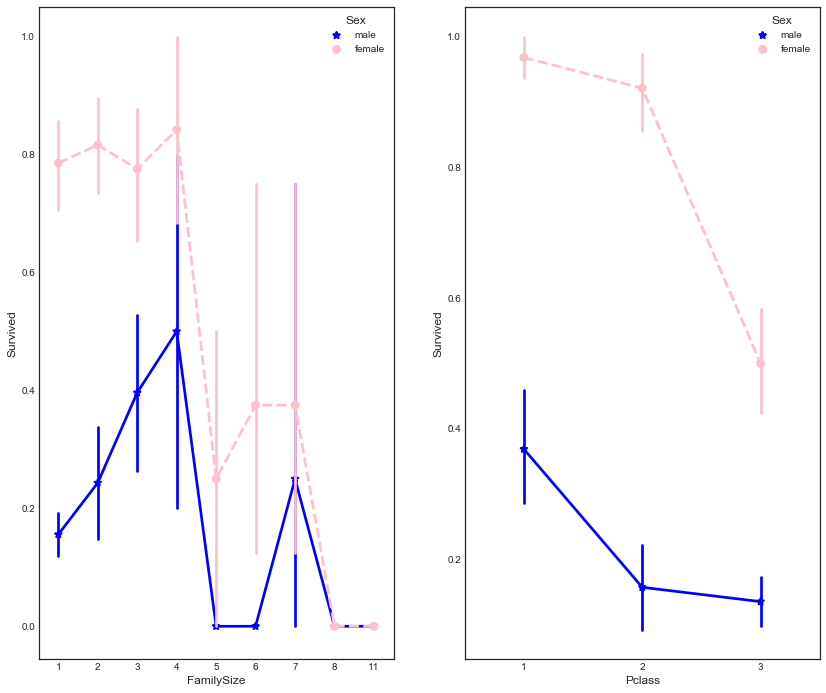

In [15]:
fig, (maxis1, maxis2) = plt.subplots(1, 2, figsize = (14, 12))

#how does family size factor with sex & survival compare
sns.pointplot(x = 'FamilySize', y = 'Survived', hue = 'Sex',
             data = train_test,
             palette = {"male": "blue", "female" : "pink"},
             markers = ["*", "o"], linestyles = ["-", "--"],
             ax = maxis1)

#how does class factor with sex & survival compare
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=train_test,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis2)

C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


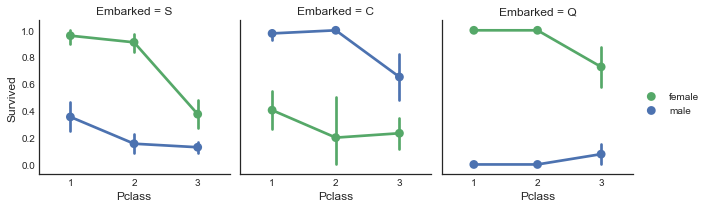

In [16]:
#how does embark port factor with class, sex, and survival compare
e = sns.FacetGrid(train_test, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex',
      ci = 95.0, palette = 'deep') # ci is confidence interval
e.add_legend()

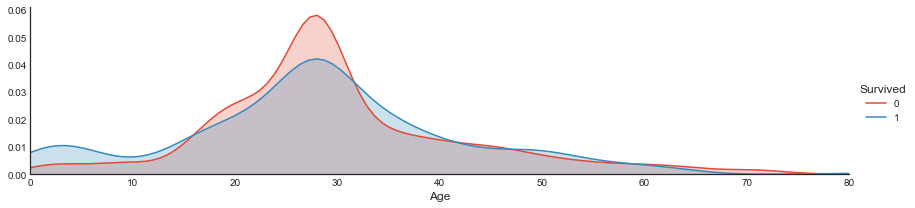

In [17]:
#plot distributions of age of passengers who survived or did not survive
a = sns.FacetGrid(train_test, hue = 'Survived', aspect = 4)
a.map(sns.kdeplot, 'Age', shade = True)
a.set(xlim=(0 , train_test['Age'].max()))
a.add_legend()

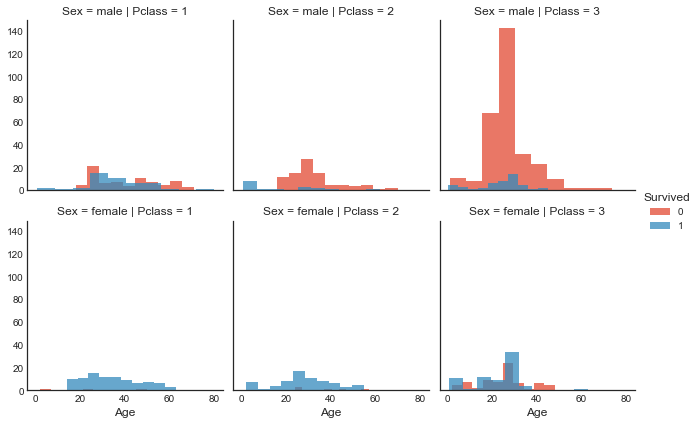

In [18]:
h = sns.FacetGrid(train_test, row = 'Sex', col = 'Pclass',
                  hue = 'Survived')
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

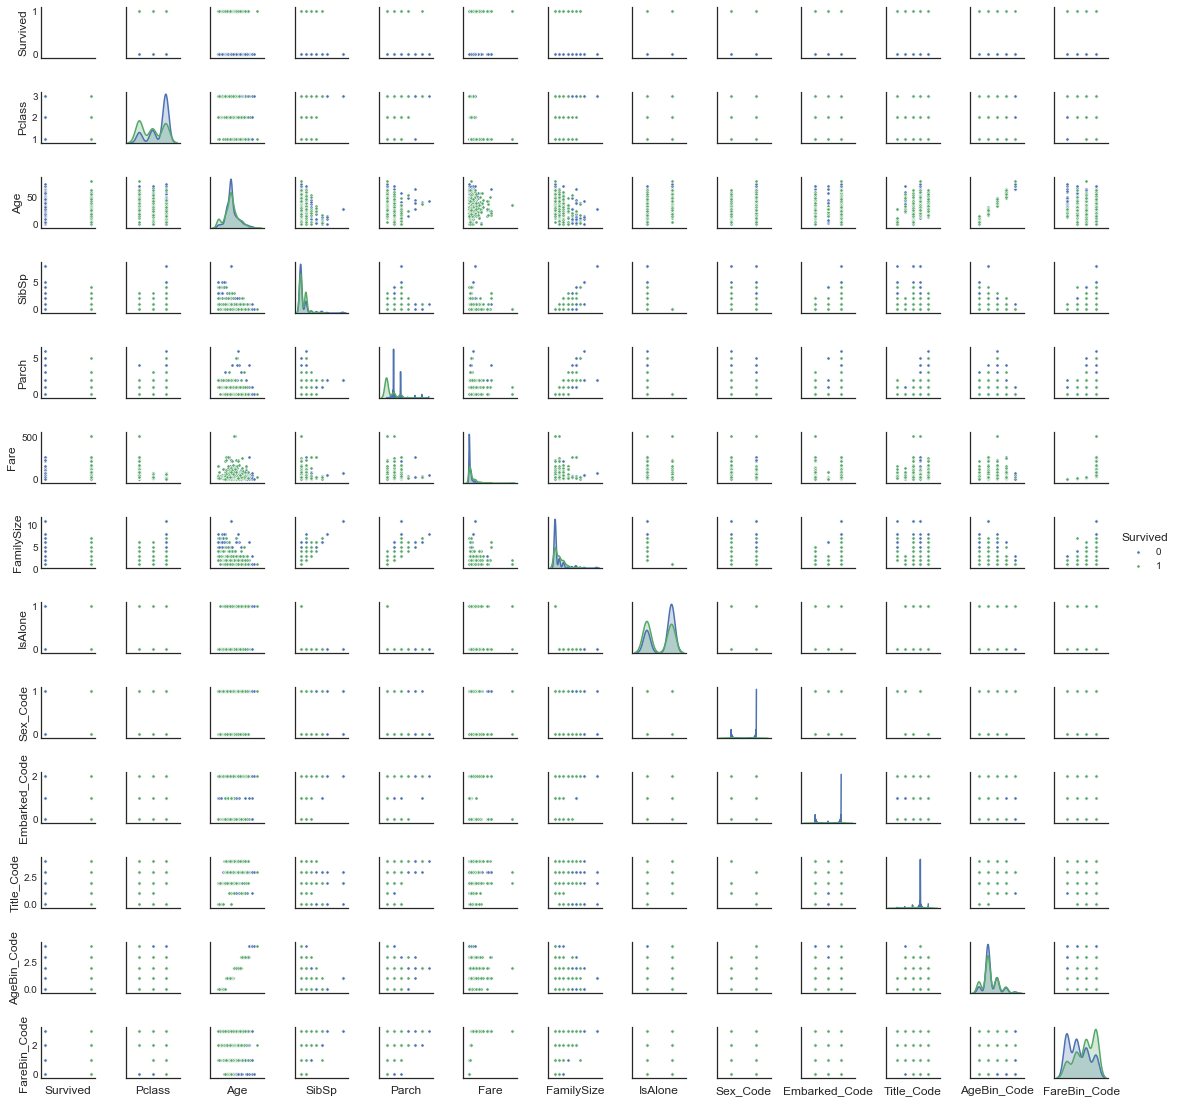

In [19]:
pp = sns.pairplot(train_test, hue = 'Survived',
                 palette = 'deep', size = 1.2,
                 diag_kind = 'kde', diag_kws = dict(shade=True),
                 plot_kws=dict(s=10))
pp.set(xticklabels=[])

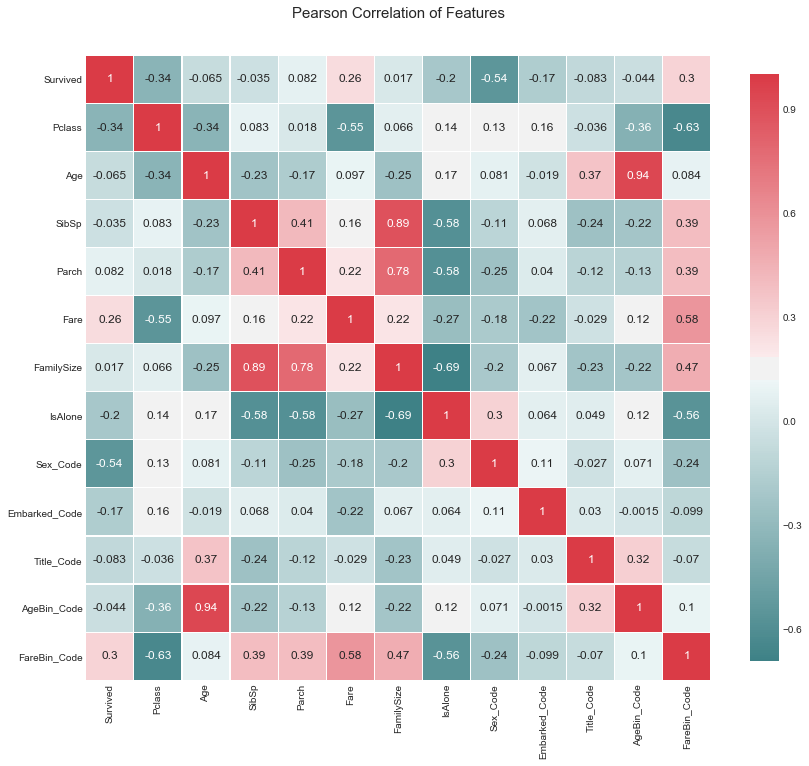

In [20]:
def correlation_heatmap(df):
    _, ax = plt.subplots(figsize = (14, 12))
    colormap = sns.diverging_palette(200, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(),
        cmap = colormap,
        square = True,
        cbar_kws = {'shrink':.9 },
        ax = ax,
        annot = True,
        linewidths = 0.1, vmax = 1.0, linecolor = 'White',
        annot_kws = {'fontsize':12}
        )
    
    plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
    
correlation_heatmap(train_test)

In [21]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
]
#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits=10,
                                       test_size=.3,
                                       train_size=.6,
                                       random_state=0)
# run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics

MLA_columns = ['MLA Name', 'MLA Parameters',
               'MLA Train Accuracy Mean', 
               'MLA Test Accuracy Mean', 
               'MLA Test Accuracy 3*STD' ,
               'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = train_test[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:
    
    #set name and parameters
    MLA_name = alg.__class__.__name__ # use the class name as the MLA name
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    # get parameters for specific alg
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    #score model with cross validation: 
    #http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, 
                                               train_test[train_test_x_bin],
                                               train_test[Target],
                                               cv = cv_split)
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean() 
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    #save MLA predictions - see section 6 for usage
    alg.fit(train_test[train_test_x_bin], train_test[Target])
    MLA_predict[MLA_name] = alg.predict(train_test[train_test_x_bin])
    row_index += 1
    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWar

C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWar

C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWar

C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:1354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversion

C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWar

C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWar

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.837266,0.826119,0.0453876,0.025329
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.895131,0.823881,0.058766,0.0106066
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.835768,0.822761,0.0493681,0.0341785
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.866667,0.822015,0.0529916,0.0419392
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.820149,0.0524569,0.00236449
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.890262,0.819776,0.0658548,0.0115379
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.891948,0.819403,0.0683111,0.0128522
18,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.814552,0.0686496,0.00312519
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.850375,0.813806,0.0690863,0.0014075
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.820412,0.81194,0.0498606,0.0510662


Text(0,0.5,'Algorithm')

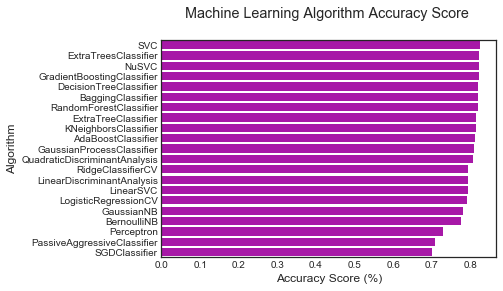

In [22]:
sns.barplot(x = 'MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

 # Evaluate Model Performance and Tune Model with Hyper-Parameter tunning

In [23]:
dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree, train_test[train_test_x_bin], train_test[Target], cv  = cv_split)
dtree.fit(train_test[train_test_x_bin], train_test[Target])

print('BEFORE DT Parameters: ', dtree.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
#print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)

#tune hyper-parameters: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              #'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              #'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              #'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              #'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
             }

#print(list(model_selection.ParameterGrid(param_grid)))

#choose best model with grid_search: #http://scikit-learn.org/stable/modules/grid_search.html#grid-search
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
tune_model.fit(train_test[train_test_x_bin], train_test[Target])

#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
print('AFTER DT Parameters: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(tune_model.cv_results_['mean_test_score'])
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT Parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 89.51
BEFORE DT Test w/bin score mean: 82.09
BEFORE DT Test w/bin score 3*std: +/- 5.57
----------
AFTER DT Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT Training w/bin score mean: 89.35
AFTER DT Test w/bin score mean: 87.40
AFTER DT Test w/bin score 3*std: +/- 5.00
----------


In [24]:
# Tune Model with Feature Selection

#base model
print('BEFORE DT RFE Training Shape Old: ', train_test[train_test_x_bin].shape) 
print('BEFORE DT RFE Training Columns Old: ', train_test[train_test_x_bin].columns.values)

print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)

#feature selection by recursive feature elimination(RFE)
dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv_split)
dtree_rfe.fit(train_test[train_test_x_bin], train_test[Target])

#transform x&y to reduced features and fit new model
#alternative: can use pipeline to reduce fit and transform steps: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
X_rfe = train_test[train_test_x_bin].columns.values[dtree_rfe.get_support()] # get the features columns with best score
rfe_results = model_selection.cross_validate(dtree, train_test[X_rfe], train_test[Target], cv = cv_split)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', train_test[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)

#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
rfe_tune_model.fit(train_test[X_rfe], train_test[Target])

#print(rfe_tune_model.cv_results_.keys())
#print(rfe_tune_model.cv_results_['params'])
print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
#print(rfe_tune_model.cv_results_['mean_train_score'])
print("AFTER DT RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(rfe_tune_model.cv_results_['mean_test_score'])
print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT RFE Training Shape Old:  (891, 7)
BEFORE DT RFE Training Columns Old:  ['Sex_Code' 'Pclass' 'Embarked_Code' 'Title_Code' 'FamilySize'
 'AgeBin_Code' 'FareBin_Code']
BEFORE DT RFE Training w/bin score mean: 89.51
BEFORE DT RFE Test w/bin score mean: 82.09
BEFORE DT RFE Test w/bin score 3*std: +/- 5.57
----------
AFTER DT RFE Training Shape New:  (891, 6)
AFTER DT RFE Training Columns New:  ['Sex_Code' 'Pclass' 'Title_Code' 'FamilySize' 'AgeBin_Code'
 'FareBin_Code']
AFTER DT RFE Training w/bin score mean: 88.16
AFTER DT RFE Test w/bin score mean: 83.06
AFTER DT RFE Test w/bin score 3*std: +/- 6.22
----------


C:\Users\cxz133630\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AFTER DT RFE Tuned Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT RFE Tuned Training w/bin score mean: 89.39
AFTER DT RFE Tuned Test w/bin score mean: 87.34
AFTER DT RFE Tuned Test w/bin score 3*std: +/- 6.21
----------


In [1]:
#Graph MLA version of Decision Tree: http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
#import graphviz 
#dot_data = tree.export_graphviz(dtree, out_file=None, 
#                                feature_names = data1_x_bin, class_names = True,
#                                filled = True, rounded = True)
#graph = graphviz.Source(dot_data) 
#graph

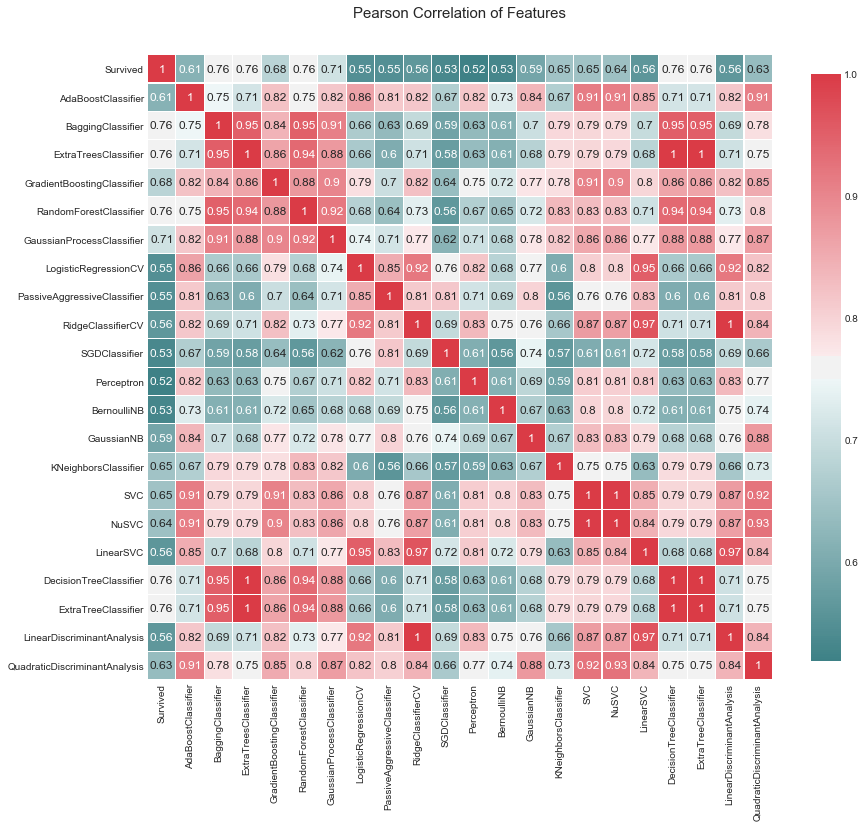

In [25]:
correlation_heatmap(MLA_predict)

In [34]:
#why choose one model, when you can pick them all with voting classifier
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#removed models w/o attribute 'predict_proba' required for vote classifier and models with a 1.0 correlation to another model
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    ('lr', linear_model.LogisticRegressionCV()),
    
    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   #('xgb', XGBClassifier())

]


#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, train_test[train_test_x_bin], train_test[Target], cv  = cv_split)
vote_hard.fit(train_test[train_test_x_bin], train_test[Target])

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, train_test[train_test_x_bin], train_test[Target], cv  = cv_split)
vote_soft.fit(train_test[train_test_x_bin], train_test[Target])

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Training w/bin score mean: 86.63
Hard Voting Test w/bin score mean: 82.09
Hard Voting Test w/bin score 3*std: +/- 3.91
----------
Soft Voting Training w/bin score mean: 87.42
Soft Voting Test w/bin score mean: 82.16
Soft Voting Test w/bin score 3*std: +/- 3.87
----------


In [33]:
#WARNING: Running is very computational intensive and time expensive.
#Code is written for experimental/developmental purposes and not production ready!


#Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [
            [{
            #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
            'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
            'random_state': grid_seed
            }],
       
    
            [{
            #BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
            'n_estimators': grid_n_estimator, #default=10
            'max_samples': grid_ratio, #default=1.0
            'random_state': grid_seed
             }],

    
            [{
            #ExtraTreesClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
             }],


            [{
            #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
            #'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'n_estimators': [300], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }],

    
            [{
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }],
    
            [{    
            #GaussianProcessClassifier
            'max_iter_predict': grid_n_estimator, #default: 100
            'random_state': grid_seed
            }],
        
    
            [{
            #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
            'random_state': grid_seed
             }],
            
    
            [{
            #BernoulliNB - http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB
            'alpha': grid_ratio, #default: 1.0
             }],
    
    
            #GaussianNB - 
            [{}],
    
            [{
            #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
            'n_neighbors': [1,2,3,4,5,6,7], #default: 5
            'weights': ['uniform', 'distance'], #default = ‘uniform’
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
            
    
            [{
            #SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
            #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'gamma': grid_ratio, #edfault: auto
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'probability': [True],
            'random_state': grid_seed
             }],

    
            [{
            #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
            'learning_rate': grid_learn, #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }]   
        ]



start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter
for clf, param in zip (vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip

    #print(clf[1]) #vote_est is a list of tuples, index 0 is the name and index 1 is the algorithm
    #print(param)
    
    
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(train_test[train_test_x_bin], train_test[Target])
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param) 


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0} with a runtime of 26.30 seconds.
The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 300, 'random_state': 0} with a runtime of 24.65 seconds.
The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0} with a runtime of 53.70 seconds.
The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 28.79 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 61.73 seconds.
The best parameter for GaussianProcessClassifier is {'max_iter_predict': 10, 'random_state': 0} with a runtime of 8.21 seconds.
The best parameter for LogisticRegressionCV is {'fit_intercept': True, 'random_stat

In [35]:
#Hard Vote or majority rules w/Tuned Hyperparameters
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard, train_test[train_test_x_bin], train_test[Target], cv  = cv_split)
grid_hard.fit(train_test[train_test_x_bin], train_test[Target])

print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)

#Soft Vote or weighted probabilities w/Tuned Hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, train_test[train_test_x_bin], train_test[Target], cv  = cv_split)
grid_soft.fit(train_test[train_test_x_bin], train_test[Target])

print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))
print('-'*10)


#12/31/17 tuned with train_test_x_bin
#The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0} with a runtime of 33.39 seconds.
#The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 300, 'random_state': 0} with a runtime of 30.28 seconds.
#The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0} with a runtime of 64.76 seconds.
#The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 34.35 seconds.
#The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 76.32 seconds.
#The best parameter for GaussianProcessClassifier is {'max_iter_predict': 10, 'random_state': 0} with a runtime of 6.01 seconds.
#The best parameter for LogisticRegressionCV is {'fit_intercept': True, 'random_state': 0, 'solver': 'liblinear'} with a runtime of 8.04 seconds.
#The best parameter for BernoulliNB is {'alpha': 0.1} with a runtime of 0.19 seconds.
#The best parameter for GaussianNB is {} with a runtime of 0.04 seconds.
#The best parameter for KNeighborsClassifier is {'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'uniform'} with a runtime of 4.84 seconds.
#The best parameter for SVC is {'C': 2, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'probability': True, 'random_state': 0} with a runtime of 29.39 seconds.
#The best parameter for XGBClassifier is {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'seed': 0} with a runtime of 46.23 seconds.
#Total optimization time was 5.56 minutes.

Hard Voting w/Tuned Hyperparameters Training w/bin score mean: 86.69
Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 82.09
Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 4.64
----------
Soft Voting w/Tuned Hyperparameters Training w/bin score mean: 87.10
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 82.09
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 4.19
----------


In [39]:
#prepare data for modeling
print(test_df.info())
print("-"*10)
#test_df.sample(10)



#handmade decision tree - submission score = 0.77990
#test_df['Survived'] = mytree(test_df).astype(int)


#decision tree w/full dataset modeling submission score: defaults= 0.76555, tuned= 0.77990
#submit_dt = tree.DecisionTreeClassifier()
#submit_dt = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
#submit_dt.fit(train_test[train_test_x_bin], train_test[Target])
#print('Best Parameters: ', submit_dt.best_params_) #Best Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
#test_df['Survived'] = submit_dt.predict(test_df[train_test_x_bin])


#bagging w/full dataset modeling submission score: defaults= 0.75119, tuned= 0.77990
#submit_bc = ensemble.BaggingClassifier()
#submit_bc = model_selection.GridSearchCV(ensemble.BaggingClassifier(), param_grid= {'n_estimators':grid_n_estimator, 'max_samples': grid_ratio, 'oob_score': grid_bool, 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_bc.fit(train_test[train_test_x_bin], train_test[Target])
#print('Best Parameters: ', submit_bc.best_params_) #Best Parameters:  {'max_samples': 0.25, 'n_estimators': 500, 'oob_score': True, 'random_state': 0}
#test_df['Survived'] = submit_bc.predict(test_df[train_test_x_bin])


#extra tree w/full dataset modeling submission score: defaults= 0.76555, tuned= 0.77990
#submit_etc = ensemble.ExtraTreesClassifier()
#submit_etc = model_selection.GridSearchCV(ensemble.ExtraTreesClassifier(), param_grid={'n_estimators': grid_n_estimator, 'criterion': grid_criterion, 'max_depth': grid_max_depth, 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_etc.fit(train_test[train_test_x_bin], train_test[Target])
#print('Best Parameters: ', submit_etc.best_params_) #Best Parameters:  {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0}
#test_df['Survived'] = submit_etc.predict(test_df[train_test_x_bin])


#random foreset w/full dataset modeling submission score: defaults= 0.71291, tuned= 0.73205
#submit_rfc = ensemble.RandomForestClassifier()
#submit_rfc = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), param_grid={'n_estimators': grid_n_estimator, 'criterion': grid_criterion, 'max_depth': grid_max_depth, 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_rfc.fit(train_test[train_test_x_bin], train_test[Target])
#print('Best Parameters: ', submit_rfc.best_params_) #Best Parameters:  {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0}
#test_df['Survived'] = submit_rfc.predict(test_df[train_test_x_bin])



#ada boosting w/full dataset modeling submission score: defaults= 0.74162, tuned= 0.75119
#submit_abc = ensemble.AdaBoostClassifier()
#submit_abc = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(), param_grid={'n_estimators': grid_n_estimator, 'learning_rate': grid_ratio, 'algorithm': ['SAMME', 'SAMME.R'], 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_abc.fit(train_test[train_test_x_bin], train_test[Target])
#print('Best Parameters: ', submit_abc.best_params_) #Best Parameters:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0}
#test_df['Survived'] = submit_abc.predict(test_df[train_test_x_bin])


#gradient boosting w/full dataset modeling submission score: defaults= 0.75119, tuned= 0.77033
#submit_gbc = ensemble.GradientBoostingClassifier()
#submit_gbc = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(), param_grid={'learning_rate': grid_ratio, 'n_estimators': grid_n_estimator, 'max_depth': grid_max_depth, 'random_state':grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_gbc.fit(train_test[train_test_x_bin], train_test[Target])
#print('Best Parameters: ', submit_gbc.best_params_) #Best Parameters:  {'learning_rate': 0.25, 'max_depth': 2, 'n_estimators': 50, 'random_state': 0}
#test_df['Survived'] = submit_gbc.predict(test_df[train_test_x_bin])

#extreme boosting w/full dataset modeling submission score: defaults= 0.73684, tuned= 0.77990
#submit_xgb = XGBClassifier()
#submit_xgb = model_selection.GridSearchCV(XGBClassifier(), param_grid= {'learning_rate': grid_learn, 'max_depth': [0,2,4,6,8,10], 'n_estimators': grid_n_estimator, 'seed': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_xgb.fit(train_test[train_test_x_bin], train_test[Target])
#print('Best Parameters: ', submit_xgb.best_params_) #Best Parameters:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'seed': 0}
#test_df['Survived'] = submit_xgb.predict(test_df[train_test_x_bin])


#hard voting classifier w/full dataset modeling submission score: defaults= 0.75598, tuned = 0.77990
#test_df['Survived'] = vote_hard.predict(test_df[train_test_x_bin])
test_df['Survived'] = grid_hard.predict(test_df[train_test_x_bin])


#soft voting classifier w/full dataset modeling submission score: defaults= 0.73684, tuned = 0.74162
#test_df['Survived'] = vote_soft.predict(test_df[train_test_x_bin])
#test_df['Survived'] = grid_soft.predict(test_df[train_test_x_bin])


#submit file
submit = test_df[['PassengerId','Survived']]
submit.to_csv("./submit.csv", index=False)

print('Validation Data Distribution: \n', test_df['Survived'].value_counts(normalize = True))
submit.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 22 columns):
PassengerId      418 non-null int64
Pclass           418 non-null int64
Name             418 non-null object
Sex              418 non-null object
Age              418 non-null float64
SibSp            418 non-null int64
Parch            418 non-null int64
Ticket           418 non-null object
Fare             418 non-null float64
Cabin            91 non-null object
Embarked         418 non-null object
FamilySize       418 non-null int64
IsAlone          418 non-null int64
Title            418 non-null object
FareBin          418 non-null category
AgeBin           418 non-null category
Sex_Code         418 non-null int64
Embarked_Code    418 non-null int64
Title_Code       418 non-null int64
AgeBin_Code      418 non-null int64
FareBin_Code     418 non-null int64
Survived         418 non-null int64
dtypes: category(2), float64(2), int64(12), object(6)
memory usage: 66.3+ KB
None
------

,PassengerId,Survived
175,1067,1
266,1158,0
293,1185,0
81,973,0
104,996,1
69,961,1
161,1053,0
357,1249,0
234,1126,1
26,918,1
